In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer 

In [2]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, 
                                                    cancer.target, stratify=cancer.target, random_state=42)
tree2 = DecisionTreeClassifier(random_state=0)
tree2.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree2.score(X_test, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.937


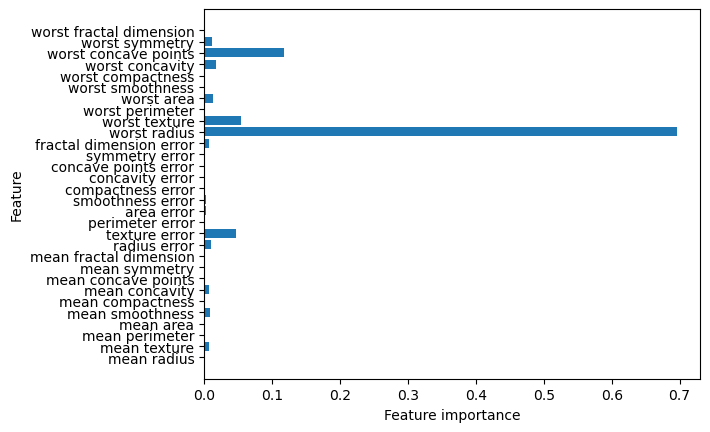

In [3]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(tree2)

As expected, the accuracy on the training set is 100%—because the leaves are pure,
the tree was grown deep enough that it could perfectly memorize all the labels on the
training data. The test set accuracy is slightly worse than for the linear models we
looked at previously, which had around 95% accuracy.
If we don’t restrict the depth of a decision tree, the tree can become arbitrarily deep
and complex. Unpruned trees are therefore prone to overfitting and not generalizing
well to new data. Now let’s apply pre-pruning to the tree, which will stop developing
the tree before we perfectly fit to the training data. One option is to stop building the
tree after a certain depth has been reached. Here we set max_depth=4, meaning only
four consecutive questions can be asked  Limiting the
depth of the tree decreases overfitting. This leads to a lower accuracy on the training
set, but an improvement on the test set:

In [4]:
tree1 = DecisionTreeClassifier(max_depth=4, random_state=0)
tree1.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree1.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


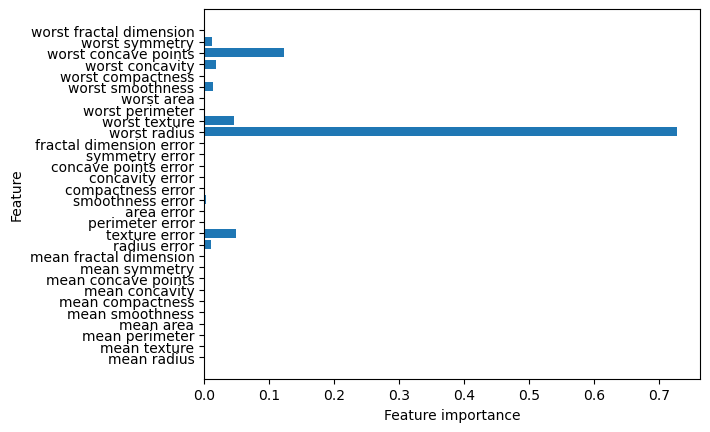

In [5]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(tree1)

We can visualize the tree using the export_graphviz function from the tree module.
This writes a file in the .dot file format, which is a text file format for storing graphs.
We set an option to color the nodes to reflect the majority class in each node and pass
the class and features names so the tree can be properly labeled:

In [6]:
print("Feature importances:\n{}".format(tree1.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


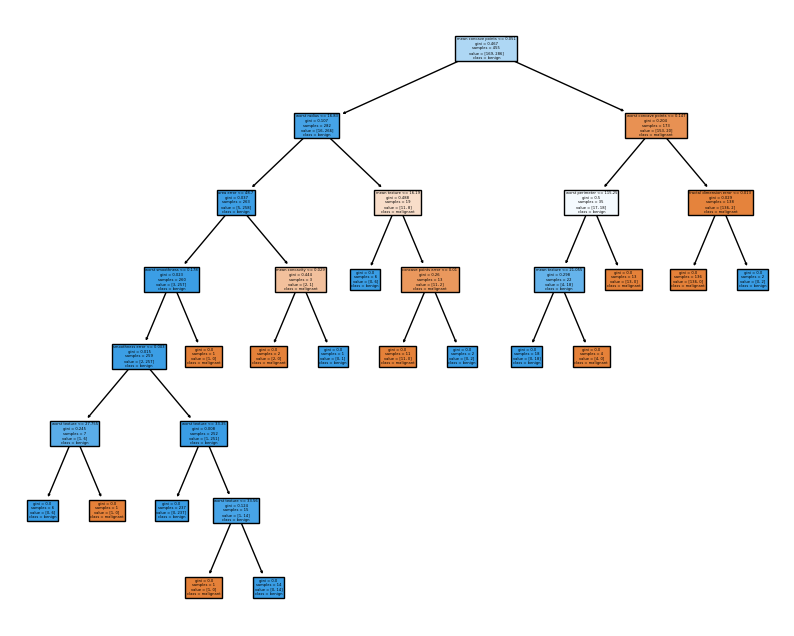

In [7]:
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load the cancer dataset
cancer = load_breast_cancer()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=42)

# Initialize the decision tree classifier and fit it to the training data
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Plot the fitted decision tree
plt.figure(figsize=(10, 8))
tree.plot_tree(clf, feature_names=cancer.feature_names, class_names=cancer.target_names, filled=True)

# Show the plot
plt.show()




We can visualize the feature importances in a way that is similar to the way we visual‐
ize the coefficients in the linear mode

Here we see that the feature used in the top split (“worst radius”) is by far the most
important feature. This confirms our observation in analyzing the tree that the first
level already separates the two classes fairly well

However, if a feature has a low feature_importance, it doesn’t mean that this feature
is uninformative. It only means that the feature was not picked by the tree, likely
because another feature encodes the same information.

In contrast to the coefficients in linear models, feature importances are always posi‐
tive, and don’t encode which class a feature is indicative of. The feature importances
tell us that “worst radius” is important, but not whether a high radius is indicative of a
sample being benign or malignant. In fact, there might not be such a simple relation‐
ship between features and class

## DECISION TREE REGRESSOR 

In [8]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()

Decision trees have two advantages over many of the algorithms we’ve discussed so
far: the resulting model can easily be visualized and understood by nonexperts (at
least for smaller trees), and the algorithms are completely invariant to scaling of the
data. As each feature is processed separately, and the possible splits of the data don’t
depend on scaling, no preprocessing like normalization or standardization of features
is needed for decision tree algorithms. In particular, decision trees work well when
you have features that are on completely different scales, or a mix of binary and con‐
tinuous features.

The main downside of decision trees is that even with the use of pre-pruning, they
tend to overfit and provide poor generalization performance. Therefore, in most
applications, the ensemble methods we discuss next are usually used in place of a sin‐
gle decision tree

## Ensembles of Decision Trees

Ensembles are methods that combine multiple machine learning models to create
more powerful models. There are many models in the machine learning literature
that belong to this category, but there are two ensemble models that have proven to
be effective on a wide range of datasets for classification and regression, both of
which use decision trees as their building blocks: random forests and gradient boos‐
ted decision trees

#### Random forests

As we just observed, a main drawback of decision trees is that they tend to overfit the
training data. Random forests are one way to address this problem. A random forest
is essentially a collection of decision trees, where each tree is slightly different from
the others. The idea behind random forests is that each tree might do a relatively
good job of predicting, but will likely overfit on part of the data. If we build many
trees, all of which work well and overfit in different ways, we can reduce the amount
of overfitting by averaging their results. This reduction in overfitting, while retaining
the predictive power of the trees, can be shown using rigorous mathematics.

To implement this strategy, we need to build many decision trees. Each tree should do
an acceptable job of predicting the target, and should also be different from the other
trees. Random forests get their name from injecting randomness into the tree build‐
ing to ensure each tree is different. There are two ways in which the trees in a random
forest are randomized: by selecting the data points used to build a tree and by select‐
ing the features in each split test. Let’s go into this process in more detail.

#### Building random forests

To build a random forest model, you need to decide on the
number of trees to build (the n_estimators parameter of RandomForestRegressor or
RandomForestClassifier). Let’s say we want to build 10 trees. These trees will be
built completely independently from each other, and the algorithm will make differ‐
ent random choices for each tree to make sure the trees are distinct. To build a tree,
we first take what is called a bootstrap sample of our data. That is, from our n_samples
data points, we repeatedly draw an example randomly with replacement (meaning the
same sample can be picked multiple times), n_samples times. This will create a data‐
set that is as big as the original dataset, but some data points will be missing from it
(approximately one third), and some will be repeated

To illustrate, let’s say we want to create a bootstrap sample of the list ['a', 'b',
'c', 'd']. A possible bootstrap sample would be ['b', 'd', 'd', 'c']. Another
possible sample would be ['d', 'a', 'd', 'a'].

Next, a decision tree is built based on this newly created dataset. However, the algo‐
rithm we described for the decision tree is slightly modified. Instead of looking for
the best test for each node, in each node the algorithm randomly selects a subset of
the features, and it looks for the best possible test involving one of these features. The
number of features that are selected is controlled by the max_features parameter.
This selection of a subset of features is repeated separately in each node, so that each
node in a tree can make a decision using a different subset of the features

The bootstrap sampling leads to each decision tree in the random forest being built
on a slightly different dataset. Because of the selection of features in each node, each
split in each tree operates on a different subset of features. Together, these two mech‐
anisms ensure that all the trees in the random forest are different

A critical parameter in this process is max_features. If we set max_features to n_fea
tures, that means that each split can look at all features in the dataset, and no ran‐
domness will be injected in the feature selection (the randomness due to the
bootstrapping remains, though). If we set max_features to 1, that means that the
splits have no choice at all on which feature to test, and can only search over different
thresholds for the feature that was selected randomly. Therefore, a high max_fea
tures means that the trees in the random forest will be quite similar, and they will be
able to fit the data easily, using the most distinctive features. A low max_features
means that the trees in the random forest will be quite different, and that each tree
might need to be very deep in order to fit the data well.

To make a prediction using the random forest, the algorithm first makes a prediction
for every tree in the forest. For regression, we can average these results to get our final
prediction. For classification, a “soft voting” strategy is used. This means each algo‐
rithm makes a “soft” prediction, providing a probability for each possible output label. The probabilities predicted by all the trees are averaged, and the class with the
highest probability is predicted.
Analyzing random forests. Let’s apply a random forest consisting of five trees to the
two_moons dataset we studied earlier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
 random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)


RandomForestClassifier(n_estimators=5, random_state=2)

In [10]:
make_moons()

(array([[ 5.18392568e-01,  8.55142763e-01],
        [-9.97945393e-01,  6.40702200e-02],
        [ 2.00000000e+00,  5.00000000e-01],
        [-5.72116660e-01,  8.20172255e-01],
        [ 9.00968868e-01,  4.33883739e-01],
        [ 1.40478334e+00, -4.14412623e-01],
        [ 1.15959990e+00, -4.87181783e-01],
        [-7.61445958e-01,  6.48228395e-01],
        [ 1.84408430e-02,  3.08841371e-01],
        [ 7.30832427e-02,  1.24732995e-01],
        [ 1.46253829e+00, -3.86599306e-01],
        [ 9.81559157e-01,  1.91158629e-01],
        [ 9.67294863e-01,  2.53654584e-01],
        [ 9.67948422e-01, -4.99486216e-01],
        [-4.62538290e-01,  8.86599306e-01],
        [ 8.71318704e-01,  4.90717552e-01],
        [ 1.62348980e+00, -2.81831482e-01],
        [ 1.00000000e+00,  0.00000000e+00],
        [ 4.62538290e-01,  8.86599306e-01],
        [-6.72300890e-01,  7.40277997e-01],
        [ 3.20515776e-02,  9.99486216e-01],
        [ 5.37461710e-01, -3.86599306e-01],
        [ 1.28681296e-01,  9.282

In [11]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.972


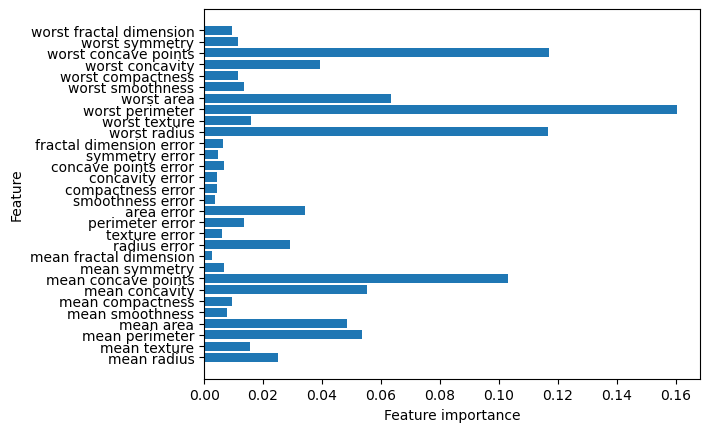

In [12]:
plot_feature_importances_cancer(forest)


the random forest gives nonzero importance to many more features
than the single tree. Similarly to the single decision tree, the random forest also gives
a lot of importance to the “worst radius” feature, but it actually chooses “worst perim‐
eter” to be the most informative feature overall. The randomness in building the ran‐
dom forest forces the algorithm to consider many possible explanations, the result
being that the random forest captures a much broader picture of the data than a sin‐
gle tree

#### Strengths, weaknesses, and parameters.
Random forests for regression and classifica‐
tion are currently among the most widely used machine learning methods. They are
very powerful, often work well without heavy tuning of the parameters, and don’t
require scaling of the data.
Essentially, random forests share all of the benefits of decision trees, while making up
for some of their deficiencies. One reason to still use decision trees is if you need a
compact representation of the decision-making process. It is basically impossible to
interpret tens or hundreds of trees in detail, and trees in random forests tend to be
deeper than decision trees (because of the use of feature subsets). Therefore, if you
need to summarize the prediction making in a visual way to nonexperts, a single
decision tree might be a better choice. While building random forests on large data‐
sets might be somewhat time consuming, it can be parallelized across multiple CPU

cores within a computer easily. If you are using a multi-core processor (as nearly all
modern computers do), you can use the n_jobs parameter to adjust the number of
cores to use. Using more CPU cores will result in linear speed-ups (using two cores,
the training of the random forest will be twice as fast), but specifying n_jobs larger
than the number of cores will not help. You can set n_jobs=-1 to use all the cores in
your computer.
You should keep in mind that random forests, by their nature, are random, and set‐
ting different random states (or not setting the random_state at all) can drastically
change the model that is built. The more trees there are in the forest, the more robust
it will be against the choice of random state. If you want to have reproducible results,
it is important to fix the random_state.
Random forests don’t tend to perform well on very high dimensional, sparse data,
such as text data. For this kind of data, linear models might be more appropriate.
Random forests usually work well even on very large datasets, and training can easily
be parallelized over many CPU cores within a powerful computer. However, random
forests require more memory and are slower to train and to predict than linear mod‐
els. If time and memory are important in an application, it might make sense to use a
linear model instead.
The important parameters to adjust are n_estimators, max_features, and possibly
pre-pruning options like max_depth. For n_estimators, larger is always better. Aver‐
aging more trees will yield a more robust ensemble by reducing overfitting. However,
there are diminishing returns, and more trees need more memory and more time to
train. A common rule of thumb is to build “as many as you have time/memory for.”
As described earlier, max_features determines how random each tree is, and a
smaller max_features reduces overfitting. In general, it’s a good rule of thumb to use
the default values: max_features=sqrt(n_features) for classification and max_fea
tures=log2(n_features) for regression. Adding max_features or max_leaf_nodes
might sometimes improve performance. It can also drastically reduce space and time
requirements for training and prediction.

### Gradient boosted regression trees (gradient boosting machines)

The gradient boosted regression tree is another ensemble method that combines mul‐
tiple decision trees to create a more powerful model. Despite the “regression” in the
name, these models can be used for regression and classification. In contrast to the
random forest approach, gradient boosting works by building trees in a serial man‐
ner, where each tree tries to correct the mistakes of the previous one. By default, there
is no randomization in gradient boosted regression trees; instead, strong pre-pruning
is used. Gradient boosted trees often use very shallow trees, of depth one to five,
which makes the model smaller in terms of memory and makes predictions faster.

The main idea behind gradient boosting is to combine many simple models (in this
context known as weak learners), like shallow trees. Each tree can only provide good
predictions on part of the data, and so more and more trees are added to iteratively
improve performance.

Gradient boosted trees are frequently the winning entries in machine learning com‐
petitions, and are widely used in industry. They are generally a bit more sensitive to
parameter settings than random forests, but can provide better accuracy if the param‐
eters are set correctly.

Apart from the pre-pruning and the number of trees in the ensemble, another impor‐
tant parameter of gradient boosting is the learning_rate, which controls how
strongly each tree tries to correct the mistakes of the previous trees. A higher learning
rate means each tree can make stronger corrections, allowing for more complex mod‐
els. Adding more trees to the ensemble, which can be accomplished by increasing
n_estimators, also increases the model complexity, as the model has more chances
to correct mistakes on the training set.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


As the training set accuracy is 100%, we are likely to be overfitting. To reduce overfit‐
ting, we could either apply stronger pre-pruning by limiting the maximum depth or
lower the learning rate

In [14]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [15]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))


Accuracy on training set: 0.988
Accuracy on test set: 0.965


Both methods of decreasing the model complexity reduced the training set accuracy,
as expected. In this case, lowering the maximum depth of the trees provided a signifi‐
cant improvement of the model, while lowering the learning rate only increased the
generalization performance slightly.
As for the other decision tree–based models, we can again visualize the feature
importances to get more insight into our model 

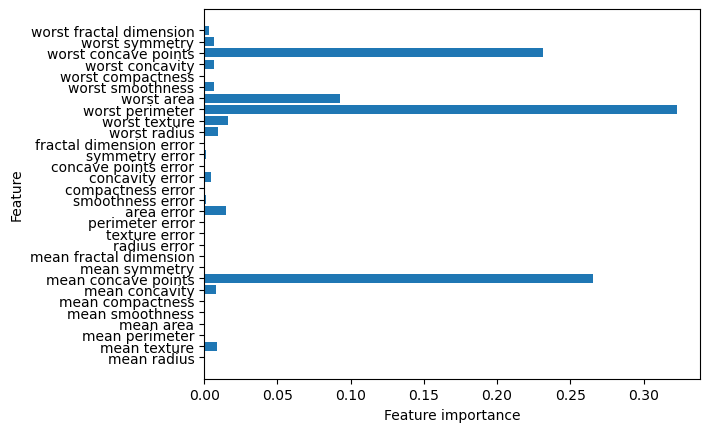

In [16]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
plot_feature_importances_cancer(gbrt)

We can see that the feature importances of the gradient boosted trees are somewhat
similar to the feature importances of the random forests, though the gradient boost‐
ing completely ignored some of the features.
As both gradient boosting and random forests perform well on similar kinds of data,
a common approach is to first try random forests, which work quite robustly. If ran‐
dom forests work well but prediction time is at a premium, or it is important to
squeeze out the last percentage of accuracy from the machine learning model, mov‐
ing to gradient boosting often helps.
If you want to apply gradient boosting to a large-scale problem, it might be worth
looking into the xgboost package and its Python interface, which at the time of writ‐
ing is faster (and sometimes easier to tune) than the scikit-learn implementation of
gradient boosting on many datasets

#### Strengths, weaknesses, and parameters.
Gradient boosted decision trees are among the
most powerful and widely used models for supervised learning. Their main drawback
is that they require careful tuning of the parameters and may take a long time to
train. Similarly to other tree-based models, the algorithm works well without scaling
and on a mixture of binary and continuous features. As with other tree-based models,
it also often does not work well on high-dimensional sparse data

The main parameters of gradient boosted tree models are the number of trees, n_esti
mators, and the learning_rate, which controls the degree to which each tree is
allowed to correct the mistakes of the previous trees. These two parameters are highly interconnected, as a lower learning_rate means that more trees are needed to build
a model of similar complexity. In contrast to random forests, where a higher n_esti
mators value is always better, increasing n_estimators in gradient boosting leads to a
more complex model, which may lead to overfitting. A common practice is to fit
n_estimators depending on the time and memory budget, and then search over dif‐
ferent learning_rates.

Another important parameter is max_depth (or alternatively max_leaf_nodes), to
reduce the complexity of each tree. Usually max_depth is set very low for gradient
boosted models, often not deeper than five splits

## Kernelized Support Vector Machines

The next type of supervised model we will discuss is kernelized support vector
machines. We explored the use of linear support vector machines for classification in
“Linear models for classification”. Kernelized support vector machines
(often just referred to as SVMs) are an extension that allows for more complex mod‐
els that are not defined simply by hyperplanes in the input space. While there are sup‐
port vector machines for classification and regression, we will restrict ourselves to the
classification case, as implemented in SVC. Similar concepts apply to support vector
regression, as implemented in SVR.

The math behind kernelized support vector machines is a bit involved, and is beyond
the scope of this book. You can find the details in Chapter 1 of Hastie, Tibshirani, and
Friedman’s e Elements of Statistical Learning. However, we will try to give you some
sense of the idea behind the method.

#### Linear models and nonlinear features

In [17]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

#### The kernel trick
The lesson here is that adding nonlinear features to the representation of our data can
make linear models much more powerful. However, often we don’t know which fea‐
tures to add, and adding many features (like all possible interactions in a 100-
dimensional feature space) might make computation very expensive. Luckily, there is
a clever mathematical trick that allows us to learn a classifier in a higher-dimensional
space without actually computing the new, possibly very large representation. This is
known as the kernel trick, and it works by directly computing the distance (more pre‐
cisely, the scalar products) of the data points for the expanded feature representation,
without ever actually computing the expansion

In [18]:
from sklearn.svm import SVC
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
 cancer.data, cancer.target, random_state=0)
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


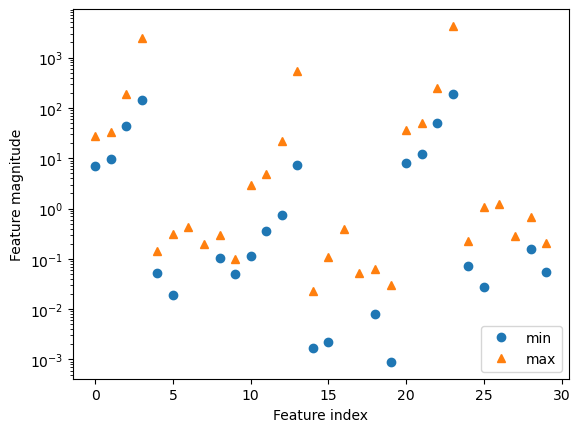

In [20]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

#### Preprocessing data for SVMs
One way to resolve this problem is by rescaling each feature so that they are all
approximately on the same scale. A common rescaling method for kernel SVMs is to
scale the data such that all features are between 0 and 1. We will see how to do this
using the MinMaxScaler preprocessing method 

In [22]:
# compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)
# subtract the min, and divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [25]:
# use THE SAME transformation on the test set,
# using min and range of the training set (see Chapter 3 for details)
X_test_scaled = (X_test - min_on_training) / range_on_training


In [26]:
svc2 = SVC()
svc2.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
 svc2.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc2.score(X_test_scaled, y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.972


Scaling the data made a huge difference


In [29]:
svc3 = SVC(C=10)
svc3.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
 svc3.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc3.score(X_test_scaled, y_test)))


Accuracy on training set: 0.988
Accuracy on test set: 0.972


Here, increasing C allows us to improve the model significantly, resulting in 97.2%
accuracy

#### Strengths, weaknesses, and parameters
Kernelized support vector machines are powerful models and perform well on a vari‐
ety of datasets. SVMs allow for complex decision boundaries, even if the data has only
a few features. They work well on low-dimensional and high-dimensional data (i.e.,
few and many features), but don’t scale very well with the number of samples. Run‐
ning an SVM on data with up to 10,000 samples might work well, but working with
datasets of size 100,000 or more can become challenging in terms of runtime and
memory usage.
Another downside of SVMs is that they require careful preprocessing of the data and
tuning of the parameters. This is why, these days, most people instead use tree-based
models such as random forests or gradient boosting (which require little or no pre‐
processing) in many applications. Furthermore, SVM models are hard to inspect; it
can be difficult to understand why a particular prediction was made, and it might be
tricky to explain the model to a nonexpert.
Still, it might be worth trying SVMs, particularly if all of your features represent
measurements in similar units (e.g., all are pixel intensities) and they are on similar
scales.
The important parameters in kernel SVMs are the regularization parameter C, the
choice of the kernel, and the kernel-specific parameters. Although we primarily
focused on the RBF kernel, other choices are available in scikit-learn. The RBF
kernel has only one parameter, gamma, which is the inverse of the width of the Gaus‐
sian kernel. gamma and C both control the complexity of the model, with large values
in either resulting in a more complex model. Therefore, good settings for the two
parameters are usually strongly correlated, and C and gamma should be adjusted
together

#### Support Vector Regressor

In [30]:
from sklearn.svm import SVR
md =SVR()

## Neural Networks (Deep Learning)

A family of algorithms known as neural networks has recently seen a revival under
the name “deep learning.” While deep learning shows great promise in many machine
learning applications, deep learning algorithms are often tailored very carefully to a
specific use case. Here, we will only discuss some relatively simple methods, namely
multilayer perceptrons for classification and regression, that can serve as a starting
point for more involved deep learning methods. Multilayer perceptrons (MLPs) are
also known as (vanilla) feed-forward neural networks, or sometimes just neural
networks


In [36]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
mlp1 = MLPClassifier(random_state=42)
mlp1.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(mlp1.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp1.score(X_test, y_test)))

Accuracy on training set: 0.94
Accuracy on test set: 0.92


The accuracy of the MLP is quite good, but not as good as the other models. As in the
earlier SVC example, this is likely due to scaling of the data. Neural networks also
expect all input features to vary in a similar way, and ideally to have a mean of 0, and a variance of 1. We must rescale our data so that it fulfills these requirements. Again,
we will do this by hand here, but we’ll introduce the StandardScaler to do this auto‐
matically

In [38]:
mean_on_train = X_train.mean(axis=0)
# compute the standard deviation of each feature on the training set
std_on_train = X_train.std(axis=0)
# subtract the mean, and scale by inverse standard deviation
# afterward, mean=0 and std=1
X_train_scaled = (X_train - mean_on_train) / std_on_train
# use THE SAME transformation (using training mean and std) on the test set
X_test_scaled = (X_test - mean_on_train) / std_on_train
mlp2 = MLPClassifier(random_state=0)
mlp2.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
 mlp2.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp2.score(X_test_scaled, y_test)))


Accuracy on training set: 0.991
Accuracy on test set: 0.965


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
mlp3 = MLPClassifier(max_iter=300, random_state=0)
mlp3.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
 mlp3.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp3.score(X_test_scaled, y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.972


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


While it is possible to analyze what a neural network has learned, this is usually much
trickier than analyzing a linear model or a tree-based model. One way to introspect
what was learned is to look at the weights in the model

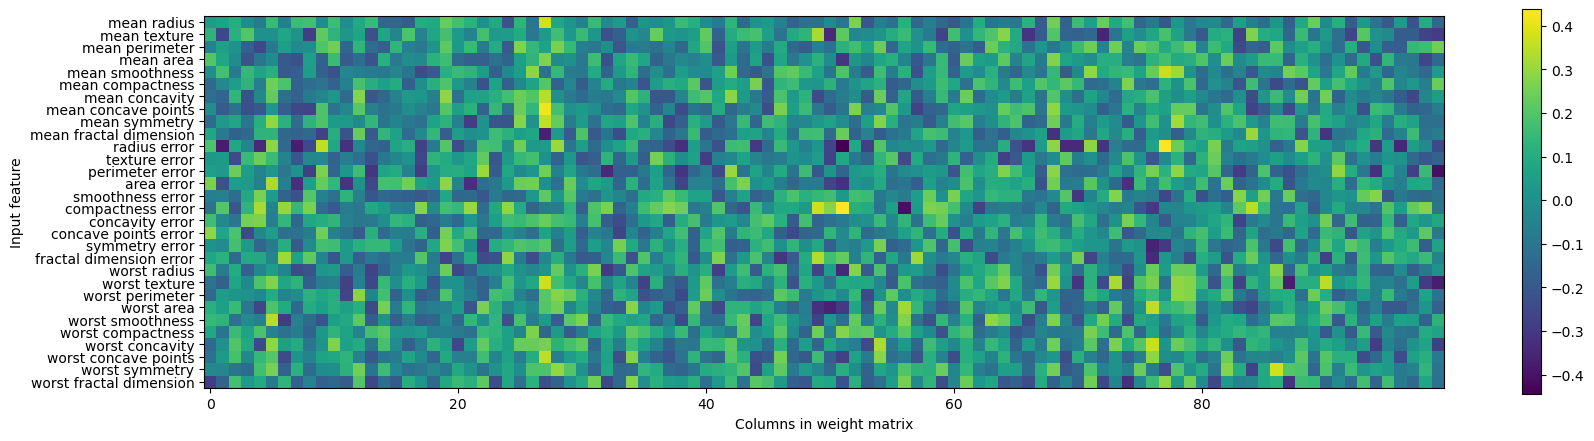

In [49]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

One possible inference we can make is that features that have very small weights for
all of the hidden units are “less important” to the model. We can see that “mean
smoothness” and “mean compactness,” in addition to the features found between
“smoothness error” and “fractal dimension error,” have relatively low weights com‐
pared to other features. This could mean that these are less important features or pos‐
sibly that we didn’t represent them in a way that the neural network could use.
We could also visualize the weights connecting the hidden layer to the output layer,
but those are even harder to interpret.
While the MLPClassifier and MLPRegressor provide easy-to-use interfaces for the
most common neural network architectures, they only capture a small subset of what
is possible with neural networks. If you are interested in working with more flexible
or larger models, we encourage you to look beyond scikit-learn into the fantastic
deep learning libraries that are out there. For Python users, the most well-established
are keras, lasagna, and tensor-flow. lasagna builds on the theano library, while
keras can use either tensor-flow or theano. These libraries provide a much more
flexible interface to build neural networks and track the rapid progress in deep learn‐
ing research. All of the popular deep learning libraries also allow the use of highperformance graphics processing units (GPUs), which scikit-learn does not
support. Using GPUs allows us to accelerate computations by factors of 10x to 100x,
and they are essential for applying deep learning methods to large-scale datasets.

#### Strengths, weaknesses, and parameters
Neural networks have reemerged as state-of-the-art models in many applications of
machine learning. One of their main advantages is that they are able to capture infor‐
mation contained in large amounts of data and build incredibly complex models.
Given enough computation time, data, and careful tuning of the parameters, neural
networks often beat other machine learning algorithms (for classification and regres‐
sion tasks).

This brings us to the downsides. Neural networks—particularly the large and power‐
ful ones—often take a long time to train. They also require careful preprocessing of
the data, as we saw here. Similarly to SVMs, they work best with “homogeneous”
data, where all the features have similar meanings. For data that has very different
kinds of features, tree-based models might work better. Tuning neural network
parameters is also an art unto itself. In our experiments, we barely scratched the sur‐
face of possible ways to adjust neural network models and how to train them

## Uncertainty Estimates from Classifiers
Another useful part of the scikit-learn interface that we haven’t talked about yet is
the ability of classifiers to provide uncertainty estimates of predictions. Often, you are
not only interested in which class a classifier predicts for a certain test point, but also
how certain it is that this is the right class. In practice, different kinds of mistakes lead
to very different outcomes in real-world applications. Imagine a medical application
testing for cancer. Making a false positive prediction might lead to a patient undergo‐
ing additional tests, while a false negative prediction might lead to a serious disease
not being treated. We will go into this topic in more detail in Chapter 6.
There are two different functions in scikit-learn that can be used to obtain uncer‐
tainty estimates from classifiers: decision_function and predict_proba. Most (but
not all) classifiers have at least one of them, and many classifiers have both. Let’s look
at what these two functions do on a synthetic two-dimensional dataset, when build‐
ing a GradientBoostingClassifier classifier, which has both a decision_function
and a predict_proba method:

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_blobs, make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)
# we rename the classes "blue" and "red" for illustration purposes
y_named = np.array(["blue", "red"])[y]
# we can call train_test_split with arbitrarily many arrays;
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
 train_test_split(X, y_named, y, random_state=0)
# build the gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

This value encodes how strongly the model believes a data point to belong to the
“positive” class, in this case class 1. Positive values indicate a preference for the posi‐
tive class, and negative values indicate a preference for the “negative” (other) class:


In [51]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(
 gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


In [52]:
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


We can recover the prediction by looking only at the sign of the decision function:

In [53]:
print("Thresholded decision function:\n{}".format(
 gbrt.decision_function(X_test) > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


For binary classification, the “negative” class is always the first entry of the classes_
attribute, and the “positive” class is the second entry of classes_. So if you want to
fully recover the output of predict, you need to make use of the classes_ attribute:

In [54]:
# make the boolean True/False into 0 and 1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# use 0 and 1 as indices into classes_
pred = gbrt.classes_[greater_zero]
# pred is the same as the output of gbrt.predict
print("pred is equal to predictions: {}".format(
 np.all(pred == gbrt.predict(X_test))))


pred is equal to predictions: True


The range of decision_function can be arbitrary, and depends on the data and the
model parameters

In [55]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
 np.min(decision_function), np.max(decision_function)))


Decision function minimum: -7.69 maximum: 4.29


This arbitrary scaling makes the output of decision_function often hard to
interpret.
In the following example we plot the decision_function for all points in the 2D
plane using a color coding, next to a visualization of the decision boundary, as we saw
earlier. 

### Predicting Probabilities
The output of predict_proba is a probability for each class, and is often more easily
understood than the output of decision_function. It is always of shape (n_samples,
2) for binary classification:


In [57]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))


Shape of probabilities: (25, 2)


The first entry in each row is the estimated probability of the first class, and the sec‐
ond entry is the estimated probability of the second class. Because it is a probability,
the output of predict_proba is always between 0 and 1, and the sum of the entries
for both classes is always 1:

In [58]:
print("Predicted probabilities:\n{}".format(
 gbrt.predict_proba(X_test[:6])))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


Because the probabilities for the two classes sum to 1, exactly one of the classes will
be above 50% certainty. That class is the one that is predicted.13
You can see in the previous output that the classifier is relatively certain for most
points. How well the uncertainty actually reflects uncertainty in the data depends on
the model and the parameters. A model that is more overfitted tends to make more
certain predictions, even if they might be wrong. A model with less complexity usu‐
ally has more uncertainty in its predictions. A model is called calibrated if the
reported uncertainty actually matches how correct it is—in a calibrated model, a pre‐
diction made with 70% certainty would be correct 70% of the time.

### UNCERTAINTY IN MULTICALSS

In [59]:
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
 iris.data, iris.target, random_state=42)
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [60]:
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# plot the first few entries of the decision function
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6, :]))


Decision function shape: (38, 3)
Decision function:
[[-1.995715    0.04758267 -1.92720695]
 [ 0.06146394 -1.90755736 -1.92793758]
 [-1.99058203 -1.87637861  0.09686725]
 [-1.995715    0.04758267 -1.92720695]
 [-1.99730159 -0.13469108 -1.20341483]
 [ 0.06146394 -1.90755736 -1.92793758]]


In the multiclass case, the decision_function has the shape (n_samples,
n_classes) and each column provides a “certainty score” for each class, where a large
score means that a class is more likely and a small score means the class is less likely.
You can recover the predictions from these scores by finding the maximum entry for
each data point:

In [61]:
print("Argmax of decision function:\n{}".format(
 np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [62]:
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# show that sums across rows are one
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
Sums: [1. 1. 1. 1. 1. 1.]


We can again recover the predictions by computing the argmax of predict_proba:

In [63]:
print("Argmax of predicted probabilities:\n{}".format(
 np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


To summarize, predict_proba and decision_function always have shape (n_sam
ples, n_classes)—apart from decision_function in the special binary case. In the
binary case, decision_function only has one column, corresponding to the “posi‐
tive” class classes_[1]. This is mostly for historical reasons.
You can recover the prediction when there are n_classes many columns by comput‐
ing the argmax across columns. Be careful, though, if your classes are strings, or you
use integers but they are not consecutive and starting from 0. If you want to compare
results obtained with predict to results obtained via decision_function or pre
dict_proba, make sure to use the classes_ attribute of the classifier to get the actual
class names

In [68]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
# represent each target by its class name in the iris dataset
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data: {}".format(logreg.classes_))
print("predictions: {}".format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function: {}".format(argmax_dec_func[:10]))
print("argmax combined with classes_: {}".format(
 logreg.classes_[argmax_dec_func][:10]))


unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


## When to use these Algorithm 
#### Nearest neighbors
For small datasets, good as a baseline, easy to explain.

Linear models
Go-to as a first algorithm to try, good for very large datasets, good for very highdimensional data.

#####  Naive Bayes
Only for classification. Even faster than linear models, good for very large data‐
sets and high-dimensional data. Often less accurate than linear models.

##### Decision trees
Very fast, don’t need scaling of the data, can be visualized and easily explained.

#####  Random forests
Nearly always perform better than a single decision tree, very robust and power‐
ful. Don’t need scaling of data. Not good for very high-dimensional sparse data.

#####  Gradient boosted decision trees
Often slightly more accurate than random forests. Slower to train but faster to
predict than random forests, and smaller in memory. Need more parameter tun‐
ing than random forests.

#####  Support vector machines
Powerful for medium-sized datasets of features with similar meaning. Require
scaling of data, sensitive to parameters.

#####  Neural networks
Can build very complex models, particularly for large datasets. Sensitive to scal‐
ing of the data and to the choice of parameters. Large models need a long time to
train.

When working with a new dataset, it is in general a good idea to start with a simple
model, such as a linear model or a naive Bayes or nearest neighbors classifier, and see
how far you can get. After understanding more about the data, you can consider
moving to an algorithm that can build more complex models, such as random forests,
gradient boosted decision trees, SVMs, or neural networks.
You should now be in a position where you have some idea of how to apply, tune, and
analyze the models we discussed here. In this chapter, we focused on the binary clas‐
sification case, as this is usually easiest to understand. Most of the algorithms presen‐
ted have classification and regression variants, however, and all of the classification
algorithms support both binary and multiclass classification. Try applying any of
these algorithms to the built-in datasets in scikit-learn, like the boston_housing or
diabetes datasets for regression, or the digits dataset for multiclass classification.
Playing around with the algorithms on different datasets will give you a better feel for how long they need to train, how easy it is to analyze the models, and how sensitive
they are to the representation of the data.
While we analyzed the consequences of different parameter settings for the algo‐
rithms we investigated, building a model that actually generalizes well to new data in
production is a bit trickier than that.